Image example: Mild Dementia


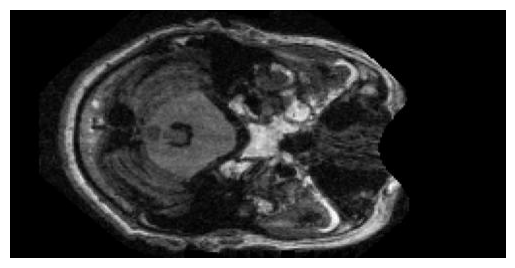

Image dimensions: (248, 496)
Number of channels: 3
Number of samples by class:
- Mild Dementia: 5002
- Moderate Dementia: 488
- Non Demented: 67222
- Very mild Dementia: 13725


In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Picking a random image to display

data_dir = '/kaggle/input/imagesoasis/Data' # Kaggle
labels = os.listdir(data_dir)
random_label = np.random.choice(labels)
random_img = np.random.choice((os.listdir(os.path.join(data_dir, random_label))))
img_path = os.path.join(data_dir, random_label, random_img)
img = plt.imread(img_path)

# Display the above image
print("Image example:", random_label)
plt.imshow(img)
plt.axis('off')
plt.show()

# Image info
print("Image dimensions:", img.shape[0:2])
print("Number of channels:", img.shape[2])

# Number of samples
print("Number of samples by class:")
for label in sorted(labels):
  print(f"- {label}: {len(os.listdir(os.path.join(data_dir, label)))}")

In [2]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as tt

# List of transforms
tf_list = tt.Compose([tt.Grayscale(), # Source files (jpg) has 3 channels. Convert them to grayscale.
                      tt.ToTensor()])

dataset = ImageFolder(data_dir, tf_list)

In [3]:
import torch
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

# Set the random seed for reproducible datasets
random_seed = 42
torch.manual_seed(random_seed)

# Split dataset
train_size = 0.7
val_size = 0.2
test_size = 0.1
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size=100
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*4, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*4, num_workers=2, pin_memory=True)

In [4]:
# Wrap data loader with this to move it to a new device
class relocated_dl():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Move data by yielding data batch by batch"""
        for batch in self.dl:
            yield move_data(batch, self.device)
    def __len__(self):
        return len(self.dl)

# Helper function
def move_data(data, device):
    if isinstance(data, (list, tuple)):
        return [move_data(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = torch.device('cuda')
train_dl = relocated_dl(train_dl, device)
val_dl = relocated_dl(val_dl, device)
test_dl = relocated_dl(test_dl, device)


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ModelBase(nn.Module):
    def train_phase(self, batch):
        imgs, labels = batch
        out = self(imgs)
        loss = F.cross_entropy(out, labels)
        return loss

    def eval_phase(self, batch):
        imgs, labels = batch
        out = self(imgs)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels) # see below
        
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def epoch_stat(self, epoch_out):
        epoch_loss = torch.stack([x['val_loss'] for x in epoch_out]).mean()
        epoch_acc = torch.stack([x['val_acc'] for x in epoch_out]).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def print_stat(self, epoch, stat):
        print("Epoch {} -- last_lr: {:.6f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, stat['lrs'][-1], stat['train_loss'], stat['val_loss'], stat['val_acc']))

In [6]:
# Helper function
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

In [7]:
class SCNN4(ModelBase):

    def __init__(self, in_ch, n_classes):
        super().__init__()                          # Size of each input tensor (channels, rows, columns):
        self.cnn1 = cnn_block(in_ch, 8, pool=False) # 1,248,496
        self.cnn2 = cnn_block(8, 16, pool=True)     # 8,248,496
        self.cnn3 = cnn_block(16, 32, pool=True)    # 16,124,248
        self.cnn4 = cnn_block(32, 64, pool=True)    # 32,61,124
        self.last = nn.Sequential(nn.Flatten(),     # 64,31,62
                                  nn.Dropout(0.2),
                                  nn.Linear(64*31*62, n_classes))

    def forward(self, xb):
        out = self.cnn1(xb)
        out = self.cnn2(out)
        out = self.cnn3(out)
        out = self.cnn4(out)
        out = self.last(out)
        return out
# Helper function
def cnn_block(in_ch, out_ch, pool=False):
    layers = [nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_ch),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [8]:
def fit(model, train_dl, val_dl, n_epochs, max_lr,
        weight_decay=0, opt_func=torch.optim.SGD
        ):

    torch.cuda.empty_cache()

    # Custom optimizer
    opt = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # One cycle learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=n_epochs,
                                                    steps_per_epoch=len(train_dl))

    history = []
    for epoch in range(n_epochs):

        # Training phase
        model.train() # Declare training phase
        train_losses = []
        lrs = []
        for batch in train_dl:
            loss = model.train_phase(batch)
            train_losses.append(loss)
            loss.backward()
            opt.step()
            opt.zero_grad()
            lrs.append(get_lr(opt))
            scheduler.step()

        # Validation phase
        stat = evaluate(model, val_dl)

        # Summarize epoch statistics
        stat['train_loss'] = torch.stack(train_losses).mean().item()
        stat['lrs'] = lrs
        model.print_stat(epoch+1, stat)

        # Save training history
        history.append(stat)

    return history

# Helper functions

@torch.no_grad() # tell PyTorch NOT to compute gradidents for evaluate()
def evaluate(model, dataloader):
    model.eval() # declare model evaluation (no randomization needed)
    epoch_out = [model.eval_phase(batch) for batch in dataloader]
    return model.epoch_stat(epoch_out)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [9]:
# Instantiate a model and move it to GPU
model = move_data(SCNN4(1, 4), device)

# Hyperparameters
n_epochs = 4
max_lr = 0.003
weight_decay = 1e-4
opt_func = torch.optim.Adam

history = fit(model, train_dl, val_dl,
              n_epochs,
              max_lr,
              weight_decay,
              opt_func
              )

Epoch 1 -- last_lr: 0.002807, train_loss: 0.8449, val_loss: 0.2986, val_acc: 0.9316
Epoch 2 -- last_lr: 0.002435, train_loss: 0.1327, val_loss: 0.0590, val_acc: 0.9753
Epoch 3 -- last_lr: 0.000849, train_loss: 0.0079, val_loss: 0.0056, val_acc: 0.9989
Epoch 4 -- last_lr: 0.000000, train_loss: 0.0020, val_loss: 0.0040, val_acc: 0.9992


In [10]:
def predict_label(img, model):
    xb = move_data(img.unsqueeze(0), # unsqueeze img to add a dimension (model only reads a batch of images)
                   device)           # move img to GPU
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

for batch in test_dl:
  for i in range(10): # Predict first 10 images in the first batch of test_dl
    img = batch[0][i]
    label = batch[1][i]
    print('| Predicted:', predict_label(img, model),
          'Label:', dataset.classes[label])
  break

| Predicted: Non Demented Label: Non Demented
| Predicted: Very mild Dementia Label: Very mild Dementia
| Predicted: Non Demented Label: Non Demented
| Predicted: Non Demented Label: Non Demented
| Predicted: Very mild Dementia Label: Very mild Dementia
| Predicted: Non Demented Label: Non Demented
| Predicted: Non Demented Label: Non Demented
| Predicted: Non Demented Label: Non Demented
| Predicted: Very mild Dementia Label: Very mild Dementia
| Predicted: Non Demented Label: Non Demented


In [11]:
stat = evaluate(model, test_dl)
stat

{'val_loss': 0.003969539888203144, 'val_acc': 0.9993181228637695}

In [12]:
torch.save(model.state_dict(), 'scnn4.pth')

In [13]:
# # Create a new model that combines the outputs of the existing CNN and ResNet50 models
# x1 = cnn_model.output  # output of the existing CNN model
# x2 = resnet_model.output  # output of the ResNet50 model
# # Change the output shape of the Reshape layer to match the input shape
# x2 = Flatten()(x2)  # flatten x2
# x = Concatenate()([x1, x2])  # concatenate the outputs
# x = Dense(128, activation='relu')(x)  # add a new dense layer
# x = Dropout(0.5)(x)  # add dropout
# x = Dense(4, activation='softmax')(x)  # add a new classification layer